In [17]:
import sys
# Sorry for this code : (
sys.path.append('../')

import numpy as np
from matplotlib import pyplot as plt
from settings import Params

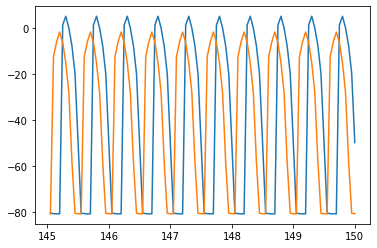

In [29]:
name = "disturbed_new"
core = 0
batch = 0

par = Params(f"../hearts/{name}/params.json")
t_start = par.get("t_start")
t_end = par.get("t_end")

states = np.load(f"../hearts/{name}/data/states_{core}_{batch}.npy")
actions = np.load(f"../hearts/{name}/data/actions_{core}_{batch}.npy")

states.shape

uProbes = states
probeUndisturbed = states.T[1]
t = np.linspace(t_start, t_end, num=probeUndisturbed.size) / 1000

indicies = t > 145

plt.plot(t[indicies], states.T[1][indicies])
plt.plot(t[indicies], states.T[0][indicies])

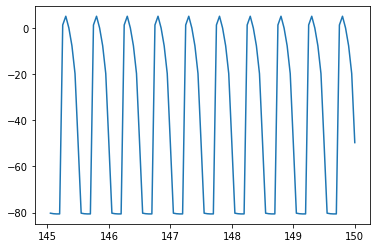

In [30]:
name = "non_disturbed_new"
core = 0
batch = 0

par = Params(f"../hearts/{name}/params.json")
t_start = par.get("t_start")
t_end = par.get("t_end")

states = np.load(f"../hearts/{name}/data/states_{core}_{batch}.npy")
actions = np.load(f"../hearts/{name}/data/actions_{core}_{batch}.npy")

states.shape

dProbes = states
probeDisturbed = states.T[1]
t = np.linspace(t_start, t_end, num=probeDisturbed.size) / 1000

indicies = t > 145

plt.plot(t[indicies], probeDisturbed[indicies])

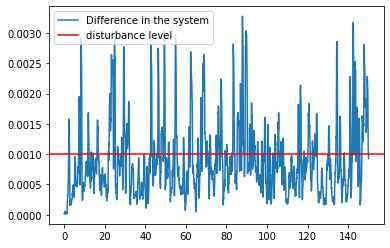

In [32]:
diffs = np.mean(np.abs(dProbes - uProbes), axis=1)

N = 10
diffs_mean = np.convolve(diffs, np.ones(N)/N, mode='sane')


t = np.linspace(t_start, t_end, num=diffs.size) / 1_000
#plt.plot(t, diffs, label="actual")
plt.plot(t, diffs_mean, label="Difference in the system")
plt.axhline(1e-3, color="red", label="disturbance level")
plt.legend()


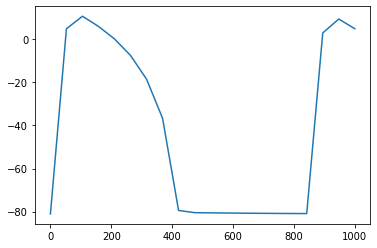

In [17]:
probe = states.T[0]
t = np.linspace(t_start, t_end, num=probe.size)

plt.plot(t, probe)

In [25]:
actions

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])